In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [2]:
train_data_dir= "Img/Train"
test_data_dir= "Img/Test"
train_data_dir = pathlib.Path(train_data_dir)
test_data_dir = pathlib.Path(test_data_dir)
image_count = len(list(train_data_dir.glob('*/*.jpg')))
image_count

85

In [3]:
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['AFace', 'NFace'], dtype='<U5')

In [4]:
faces = list(train_data_dir.glob('faces/*'))

for image_path in faces[:3]:
    display.display(Image.open(str(image_path)))

In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1. / 255,
    zoom_range=0.2,
    rotation_range = 5,
    horizontal_flip=True)


In [6]:
BATCH_SIZE = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150
EPOCH = 50
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_data_gen = image_generator.flow_from_directory(
    directory=str(train_data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = list(CLASS_NAMES))

test_data_gen = image_generator.flow_from_directory(  
    directory=str(test_data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = list(CLASS_NAMES))

Found 85 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [7]:
nb_validation_samples=76
train_samples=86
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

10


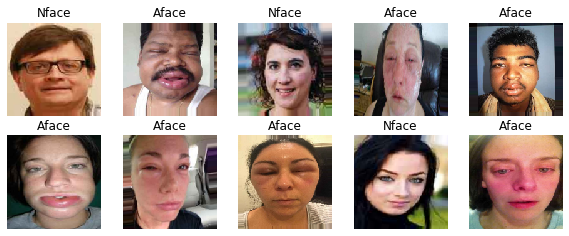

In [8]:
image_batch, label_batch = next(test_data_gen)
show_batch(image_batch, label_batch)
print(len(image_batch))

In [18]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from fan import fan_speed
import pickle

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(128))

model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks_list = [early_stop, reduce_lr]  

fan_speed(250)

model_history = model.fit_generator(  
    train_data_gen,
    epochs=EPOCH,
    steps_per_epoch=train_samples // BATCH_SIZE,
    validation_data=test_data_gen,
    validation_steps=nb_validation_samples // BATCH_SIZE,
    callbacks=callbacks_list)



fan_speed(120)
# Plot training & validation accuracy values
model.save('Av2.models')

# Save Vars

pickle_out = open("Vars/acc.pickle","wb")
pickle.dump(model_history.history['accuracy'], pickle_out)
pickle_out.close()
pickle_out = open("Vars/loss.pickle","wb")
pickle.dump(model_history.history['loss'], pickle_out)
pickle_out.close()
pickle_out = open("Vars/accr.pickle","wb")
pickle.dump(model_history.history['val_accuracy'], pickle_out)
pickle_out.close()
pickle_out = open("Vars/lossr.pickle","wb")
pickle.dump(model_history.history['val_loss'], pickle_out)
pickle_out.close()
pickle_out = open("Vars/imge.pickle","wb")
pickle.dump(image_count, pickle_out)
pickle_out.close()
pickle_out = open("Vars/epp.pickle","wb")
pickle.dump(len(acce), pickle_out)
pickle_out.close()

255
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 7 steps
Epoch 1/50
8/8 [==============================] - 2s 288ms/step - loss: 5.7614 - accuracy: 0.4750 - val_loss: 0.8508 - val_accuracy: 0.5714
Epoch 2/50
8/8 [==============================] - 2s 236ms/step - loss: 0.6753 - accuracy: 0.6333 - val_loss: 0.6517 - val_accuracy: 0.6286
Epoch 3/50
8/8 [==============================] - 2s 229ms/step - loss: 0.6366 - accuracy: 0.7200 - val_loss: 0.7093 - val_accuracy: 0.5714
Epoch 4/50
8/8 [==============================] - 2s 229ms/step - loss: 0.5421 - accuracy: 0.7267 - val_loss: 0.6753 - val_accuracy: 0.5714
Epoch 5/50
8/8 [==============================] - 2s 236ms/step - loss: 0.4977 - accuracy: 0.7688 - val_loss: 0.5341 - val_accuracy: 0.7214
Epoch 6/50
8/8 [==============================] - 2s 243ms/step - loss: 0.4395 - accuracy: 0.8313 - val_loss: 0.5841 - val_accuracy: 0.7286
Epoch 7/50
8/8 [==============================] - 2s 229ms/step - 

21


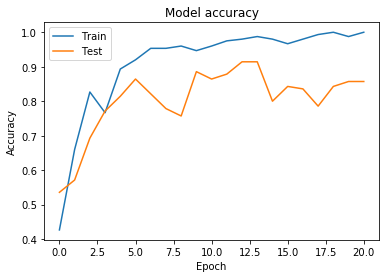

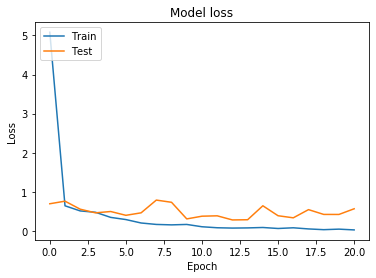

In [17]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

pickle_in = open("Vars/epp.pickle","rb")
epp= pickle.load(pickle_in)
pickle_in = open("Vars/acc.pickle","rb")
acce = pickle.load(pickle_in)
pickle_in = open("Vars/loss.pickle","rb")
losse= pickle.load(pickle_in)
pickle_in = open("Vars/accr.pickle","rb")
accer = pickle.load(pickle_in)
pickle_in = open("Vars/lossr.pickle","rb")
losser= pickle.load(pickle_in)
pickle_in = open("Vars/imge.pickle","rb")
image = pickle.load(pickle_in)

plt.plot(acce)
plt.plot(accer)

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(losse)
plt.plot(losser)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

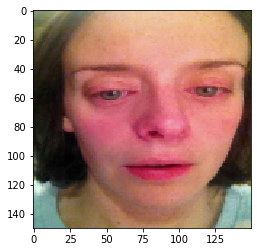

Model Result
AFace
['AFace', 'NFace']
[0.9979995  0.00146697]
Real Result
AFace


In [11]:
from tensorflow.keras.models import load_model

model = load_model("Av2.models")
CATEGORIES = ["AFace","NFace"]

n=BATCH_SIZE-1
prediction3 = model.predict(image_batch[n].reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3))
plt.imshow(image_batch[n])  # graph it
plt.show()  # display!
print("Model Result")
print(CATEGORIES[np.argmax(prediction3[0])])
print(CATEGORIES)
print(prediction3[0])
print("Real Result")
print(CATEGORIES[int(label_batch[n][1])])

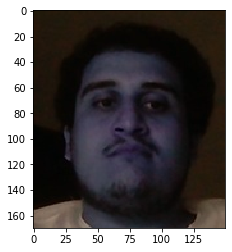

NFace
[0.07256949 0.9581825 ]


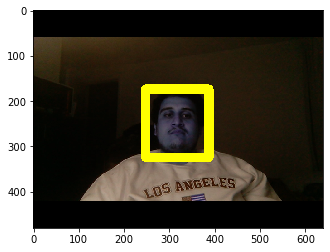

In [12]:
import cv2 
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
%matplotlib inline

CATEGORIES = ["AFace","NFace"]

def prepare(filepath):
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
    new_array = new_array.astype('float32')/255
    return new_array.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)

model = load_model("Av2.models")

face_cascade = cv2.CascadeClassifier('Haar/haarcascade_frontalface_default.xml') 
capture = cv2.VideoCapture(0) 

reg, webcamFrame = capture.read() 
grayImage = cv2.cvtColor(webcamFrame, cv2.COLOR_BGR2GRAY) 

faces = face_cascade.detectMultiScale(grayImage, 1.3, 5) 

for (x,y,w,h) in faces: 
    crop_img = webcamFrame[y-25:y+h+25, x-15:x+w+15]
    cv2.imwrite("input.jpg", crop_img) 
    cv2.rectangle(webcamFrame,(x-10,y-10),(x+w+10,y+h+20),(255,255,0),20) 
    roi_gray = grayImage[y:y+h, x:x+w] 
    roi_color = webcamFrame[y:y+h, x:x+w]
    prediction = model.predict([prepare('input.jpg')])
    img_array = cv2.imread('input.jpg')  # convert to array
    plt.imshow(img_array)  # graph it
    plt.show()  # display!
    print(CATEGORIES[np.argmax(prediction[0])]) 
    print(prediction[0])
    plt.imshow(webcamFrame)

capture.release()
cv2.destroyAllWindows()

In [26]:
import paho.mqtt.client as paho
import time
import ssl
import cv2 
import boto3
from tensorflow.keras.models import load_model
import pickle

pickle_in = open("Vars/epp.pickle","rb")
epp= pickle.load(pickle_in)
pickle_in = open("Vars/acc.pickle","rb")
acce = pickle.load(pickle_in)
pickle_in = open("Vars/loss.pickle","rb")
losse= pickle.load(pickle_in)
pickle_in = open("Vars/accr.pickle","rb")
accer = pickle.load(pickle_in)
pickle_in = open("Vars/lossr.pickle","rb")
losser= pickle.load(pickle_in)
pickle_in = open("Vars/imge.pickle","rb")
image = pickle.load(pickle_in)

chl = [0,round(epp*0.1),round(epp*0.2),round(epp*0.3),round(epp*0.4),round(epp*0.5),round(epp*0.6),round(epp*0.7),round(epp*0.8),round(epp*0.9),epp]

ch1d = [0,acce[round(epp*0.1)],acce[round(epp*0.2)],acce[round(epp*0.3)],acce[round(epp*0.4)],acce[round(epp*0.5)],acce[round(epp*0.6)],acce[round(epp*0.7)],acce[round(epp*0.8)],acce[round(epp*0.9)],acce[epp-1]]

ch2d = [losse[0],losse[round(epp*0.1)],losse[round(epp*0.2)],losse[round(epp*0.3)],losse[round(epp*0.4)],losse[round(epp*0.5)],losse[round(epp*0.6)],losse[round(epp*0.7)],losse[round(epp*0.8)],losse[round(epp*0.9)],losse[epp-1]]

send = (   
       ' {'
       ' "images":'+str(image)+','
       ' "epochs":'+str(epp)+','
       ' "acc":'+str(round(acce[epp-1]*100,6))+','
       ' "loss":'+str(round(losse[epp-1],6))+','
       ' "chl":'+str(chl)+','
       ' "ch1d":'+str(ch1d)+','
       ' "ch2d":'+str(ch2d)+''
       '}'
        )
        

model = load_model("Av2.models")

s3_client = boto3.client('s3')

EndPoint = "a1nic3lezioefw-ats.iot.us-east-1.amazonaws.com"
caPath = "Certs/aws-iot-rootCA.crt"
certPath = "Certs/2e1284e5e6-certificate.pem.crt"
keyPath = "Certs/2e1284e5e6-private.pem.key"

def on_connect(client, userdata, flags, rc):
    print("Connection returned result: " + str(rc) )
    #client.subscribe("#" , 1 ) # Wild Card

def on_message(client, userdata, msg):
    if(msg.topic=='/ChartsInfoS'):
        mqttc.publish('/ChartsInfoR', send)
    print("topic: "+msg.topic)
    print("payload: "+str(msg.payload))
    
def on_publish(client, obj, mid):
    print("mid: " + str(mid))
    
def on_subscribe(client, obj, mid, granted_qos):
    print("Subscribed: " + str(mid) + " " + str(granted_qos))
    
def prepare(filepath):
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
    new_array = new_array.astype('float32')/255
    return new_array.reshape(-1,IMG_HEIGHT, IMG_WIDTH, 3)

mqttc = paho.Client()
mqttc.on_connect = on_connect
mqttc.on_message = on_message
mqttc.on_publish = on_publish
mqttc.on_subscribe = on_subscribe

mqttc.tls_set(caPath, certfile=certPath, keyfile=keyPath, cert_reqs=ssl.CERT_REQUIRED, tls_version=ssl.PROTOCOL_TLSv1_2, ciphers=None)

mqttc.connect(EndPoint, 8883, keepalive=60)

rc = 0

mqttc.subscribe('/ChartsInfoS')

tick = 29

while rc == 0:
    rc = mqttc.loop()
    if(tick == 30):
        tick=0
        face_cascade = cv2.CascadeClassifier('Haar/haarcascade_frontalface_default.xml') 
        capture = cv2.VideoCapture(0) 

        reg, webcamFrame = capture.read() 
        grayImage = cv2.cvtColor(webcamFrame, cv2.COLOR_BGR2GRAY) 

        faces = face_cascade.detectMultiScale(grayImage, 1.3, 5) 

        for (x,y,w,h) in faces: 
            crop_img = webcamFrame[y-50:y+h+100, x-30:x+w+30]
            cv2.imwrite("input.jpg", crop_img) 
            cv2.rectangle(webcamFrame,(x-30,y-50),(x+w+30,y+h+100),(255,255,0),20) 
            roi_gray = grayImage[y:y+h, x:x+w] 
            roi_color = webcamFrame[y:y+h, x:x+w]
            prediction = model.predict([prepare('input.jpg')])
            response = s3_client.upload_file('input.jpg', 'hackster-hackster', 'input.jpg',ExtraArgs={'ACL': 'public-read'})
            img_array1 = cv2.imread('input.jpg',cv2.IMREAD_GRAYSCALE)  # convert to array 
            print(CATEGORIES[np.argmax(prediction[0])])
            if(CATEGORIES[np.argmax(prediction[0])]=="AFace"):
                new = """ {
                "name":"Victor Alonso Altamirano Izquierdo",
                "gen":"25 year old male patient",
                "hr":"Heart Rate 142",
                "temp":"Temp: 102.2 °F",
                "stat":"Status: Anaphylaxis phase 3, URGENT"
                }"""
                mqttc.publish('/JetsonAI1R', new)
        capture.release()
        cv2.destroyAllWindows()
    tick = tick +1
    print(tick)
    time.sleep(1)
    
print("rc: " + str(rc))

30
Connection returned result: 0
AFace
mid: 2
1
Subscribed: 1 (0,)
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 